In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
%matplotlib inline
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from obspy import Trace, Stream, UTCDateTime, read
from matplotlib.mlab import psd, magnitude_spectrum
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
import matplotlib.image as mpimg
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.morphology import skeletonize
from skimage.transform import rotate, hough_line, hough_line_peaks
import scipy.signal as ss

from obspy.signal.spectral_estimation import get_nlnm, get_nhnm

import matplotlib as mpl
mpl.rcParams['date.autoformatter.day'] = "%Y-%m-%d"
mpl.rcParams['date.autoformatter.hour'] = "%Y-%m-%d %Hh"
mpl.rcParams['date.autoformatter.minute'] = "%Y-%m-%d %H:%M"

mpl.rcParams['figure.figsize'] = "12,8"
mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['axes.axisbelow'] = True


In [3]:
import seaborn as sns

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [5]:
def restitution_galitzin(ym, Tp=None, kind='horizontal', plot=False, show=True):
    if Tp is None:
        Tp = np.logspace(-1,2,num=200)
    if kind == "horizontal":

        T = 21.5
        T1 = 21.8
        l = 124.7
        mu = 0.2
        A1 = 1040.0
        k = 38.0
    
    elif kind == "vertical":
        T = 10.0
        T1 = 10.15
        l = 173.8 # somville 1937
        mu = 0.0
        A1 = 1060.0 #Somville 1930 bulletin
        k = 290.0 /3.0 # somville 1953  bulletin + correction based on data! See Lecocq et al 2020
        
    else:
        print("kind must be either horizontal or vertical, quitting")
        return False

    u = Tp / T
    u1 = Tp / T1

    fu = (2.*u/(1.+u**2))**2
    C1 = np.pi * l / (k*A1)
    xm = C1 * ym/Tp * (1.+u**2)  * (1.+u1**2)  * np.sqrt(1.-fu*mu**2)
    
    if plot:
        
#         plt.title("ROB Galitzin Seismometer Amplitude Response (%s)" % )
        base, = plt.loglog(Tp,1./xm, lw=2)
        maxx = np.argmax(1./xm)
        plt.axvline(Tp[maxx], c=base.get_color(), ls="--", 
                    label='%s Maximum: %.1f at %.1f s'%(kind.capitalize(), 1./xm[maxx], Tp[maxx]))
        plt.grid(which='both')
        plt.xlabel("Period (s)")
        plt.ylabel("Amplification")
        plt.legend(loc=2)
        if show:
            plt.show()
    return xm

In [9]:
import netCDF4
models = {}
full_model = {}
pmax = {}
def rms(a):
    sel = a.loc[0.08:0.32]
    return np.sqrt(np.trapz(sel.values, sel.index))*1.0e6

for ncname in sorted(glob.glob(r"model/UCC_195301-195311_Q0*REF102040_edzf.nc")):
    nc = netCDF4.Dataset(ncname)
    edzf = nc.variables["edzf"]
    times = nc.variables['time']
    freqsnc = nc.variables['frequency']
    jd = netCDF4.num2date(times[:],times.units)
    model = pd.DataFrame(edzf[:,0,:],index=jd, columns=freqsnc)
    freqsnc = model.columns
    full_model[os.path.split(ncname)[1]] = model
    pmax[os.path.split(ncname)[1]] = model.idxmax(axis=1)
    test2 = model.apply(rms, axis=1)
    models[os.path.split(ncname)[1]] = test2


In [22]:
comps = {}
comps["Z"] = ("1953.BHZ.mseed", "vertical")


In [23]:
results = {}

for comp in comps:
    file, orientation = comps[comp]
    all_x = []
    all_pxx = []
    all_times = []
    all_disp = []
    all_domP = []
    
    st = read(file)
    for tr in st.traces:
        _ = tr.data.copy()

        pxx, freqs = psd(tr.data, Fs=tr.stats.sampling_rate, pad_to=1024, detrend="mean", noverlap=8, scale_by_freq=True)
        all_disp.append(np.max(np.abs(tr.data)))
        if orientation == "horizontal":
            maxP = np.min([20., 1./freqs[np.argmax(pxx)]])
        else:
            maxP = np.min([12, 1./freqs[np.argmax(pxx)]])
        amp =  restitution_galitzin(_, maxP, kind=orientation, plot=False)
        pxx, freqs = psd(amp, Fs=tr.stats.sampling_rate, pad_to=1024, detrend="mean", noverlap=8, scale_by_freq=True)

        all_domP.append(maxP)

        all_x.append(freqs)
        all_pxx.append(pxx)

        all_times.append(tr.stats.starttime.datetime)

    # storing spectrum
    spectrogram = pd.DataFrame(all_pxx, columns=all_x[0], index=all_times)
    
    # storing displacement
    amp =  restitution_galitzin(np.ones(len(all_domP)),np.array(all_domP), kind=orientation, plot=False)
    displacement = pd.Series(np.array(all_disp)*amp*1e6, index=pd.DatetimeIndex(all_times))
    
    results[comp] = (spectrogram, displacement)

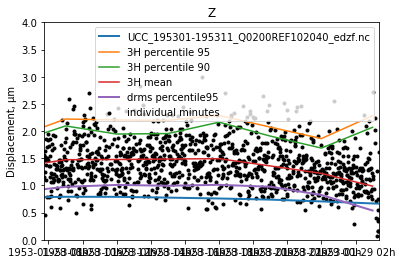

In [24]:
for comp in results:
    s, d = results[comp]
    s = s.copy()
    d = d.copy()
    
    plt.figure()

    for model in models:
    #     if model.count("Q0200") != 0 or model.count("Q0300") != 0:
        if model.count("Q0200") != 0:        
            label = model
            model = models[model]
            plt.plot(model.index, model, label=label, lw=2)

    plt.scatter(d.index, d , marker=".", c='k', label="individual minutes")
    r = d.resample("3H").quantile(0.95)
    plt.plot(r.index, r , label="3H percentile 95")
    r = d.resample("3H").quantile(0.90)
    plt.plot(r.index, r ,  label="3H percentile 90")
    r = d.resample("3H").mean()
    plt.plot(r.index, r , label="3H mean")

    drms = s.copy().resample("3H").quantile(0.95)
    drms = drms.apply(rms, axis=1)
    plt.plot(drms.index, drms, lw=2, label="drms percentile95")

    plt.ylim(0,4)
    plt.xlim(s.index[0], s.index[-1])
    plt.legend()
    plt.ylabel("Displacement, µm")
    plt.title(comp)
    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


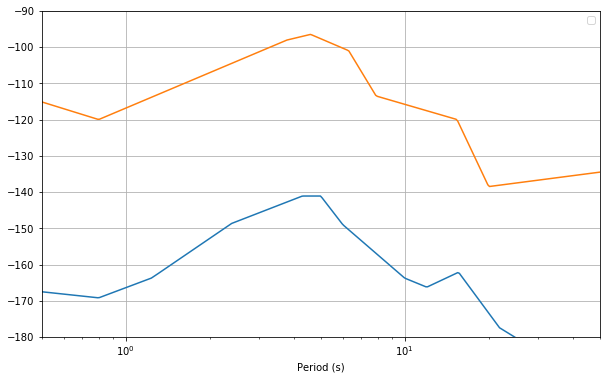

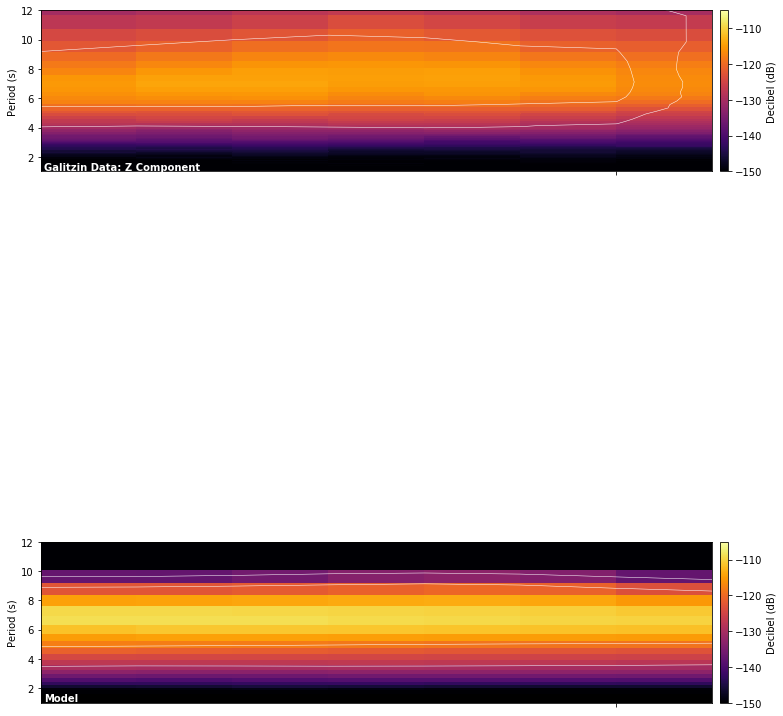

In [25]:

spectrograms = {}
spectrograms_full = {}

cmap = plt.get_cmap('inferno')
cmap.set_bad(color = 'k', alpha = 1)


vmin = -150
vmax = -105


fig = plt.figure(figsize=(10,6))
PSD = plt.subplot(111)
p, a = get_nlnm()
plt.plot(p, a)
p, a = get_nhnm()
plt.semilogx(p, a)
plt.legend()

plt.xlabel("Period (s)")
plt.grid()

plt.figure(figsize=(12,10))
i = 1
for comp in results:
    s, d = results[comp]
    s = s.copy()
    d = d.copy()
    
    if i == 1:
        ax = plt.subplot(4,1,1)
    else:
        ax = plt.subplot(4, 1, i, sharex=ax, sharey=ax)
    plt.ylabel("Period (s)")
    db = s.iloc[:,1:]

    db = 10.0 * np.log10(db)
    tmp = db.resample("5min").quantile(0.5).T 
    spectrograms_full[comp] = tmp
    
    db = db.resample("3H").quantile(0.5).T
#     PSD.plot(1./db.index, db.median(axis=1), label=comp)
    X, Y = np.meshgrid(db.columns, 1./db.index)
    c = plt.pcolormesh(db.columns, 1./db.index, db, cmap=cmap,  rasterized=True, vmax=vmax, vmin=vmin, edgecolors='none')
    spectrograms[comp] = db
    cb = plt.colorbar(orientation="vertical", pad=0.01)
    cb.set_label('Decibel (dB)')
    
    plt.contour(X, Y, db, levels=[-130,-120], colors='w', linestyles="-", linewidths=0.5)
    
    plt.axvline(UTCDateTime("1953-02-01 00:00").datetime, c='w', ls='--')
    
    plt.text(0.005, 0.01, "Galitzin Data: %s Component"%comp, transform=ax.transAxes, c='w',weight="bold" )
    
    i+=1
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)


    
ax = plt.subplot(414, sharex=ax, sharey=ax, facecolor="k" )


m = full_model["UCC_195301-195311_Q0200REF102040_edzf.nc"]
m = m.loc[db.columns[0]:db.columns[-1],:]
m = 10. * np.log10(m)

c = plt.pcolormesh(m.index, 1./m.columns, m.T, cmap=cmap,  rasterized=True, vmax=vmax, vmin=vmin)
cb = plt.colorbar(orientation="vertical", pad=0.01)
cb.set_label('Decibel (dB)')
X, Y = np.meshgrid(m.index, 1./m.columns)
plt.contour(X, Y, m.T, levels=[-130,-120], colors='w', linestyles="-", linewidths=0.5)

plt.text(0.005, 0.01, "Model", transform=ax.transAxes, c='w',weight="bold" )
plt.ylabel("Period (s)")
plt.axvline(UTCDateTime("1953-02-01 00:00").datetime, c='w', ls='--')

dr = pd.date_range(m.index[0].date(), m.index[-1].date(), freq="D")
drl = []
for i, d in enumerate(dr):
    if i % 2 == 0:
        drl.append(d.strftime("%Y-%m-%d"))
    else:
        drl.append("")

plt.xticks(dr, drl)
plt.xlim(db.columns[0], db.columns[-1])
plt.gcf().autofmt_xdate()

plt.ylim(1,12)
# plt.grid(True)


plt.tight_layout(h_pad=0.02)
plt.subplots_adjust(hspace=0.1)
plt.savefig("Spectrograms.png")

plt.sca(PSD)
plt.legend()
plt.xlim(0.5,50)
plt.ylim(-180,-90)

plt.show()

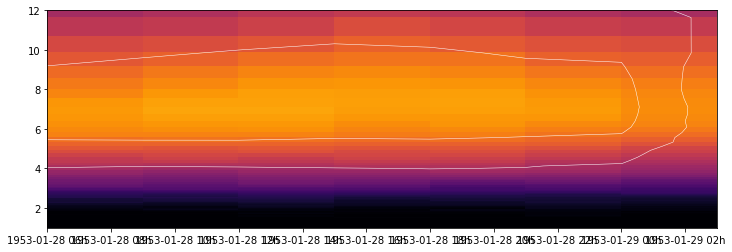

1953-01-28 06:00:00    0.443816
1953-01-28 09:00:00    0.487492
1953-01-28 12:00:00    0.506393
1953-01-28 15:00:00    0.487802
1953-01-28 18:00:00    0.492620
Freq: 3H, dtype: float64


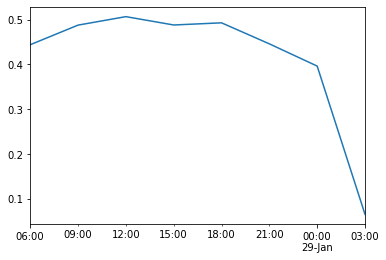

In [26]:
sp = pd.concat(spectrograms)
mm = sp.mean(level=1).T
plt.figure(figsize=(12,4))
c = plt.pcolormesh(mm.index, 1./mm.columns, mm.T, cmap=cmap,  rasterized=True, vmax=vmax, vmin=vmin)
X, Y = np.meshgrid(mm.index, 1./mm.columns)
plt.contour(X, Y, mm.T, levels=[-130,-120], colors='w', linestyles="-", linewidths=0.5)
plt.ylim(1,12)
plt.show()

mm = mm.dropna()
mm = 10**(mm/10.)
test2 = mm.apply(rms, axis=1)
test2 = test2.asfreq("3H")
print(test2.head())
plt.figure()
test2.plot()
plt.show()

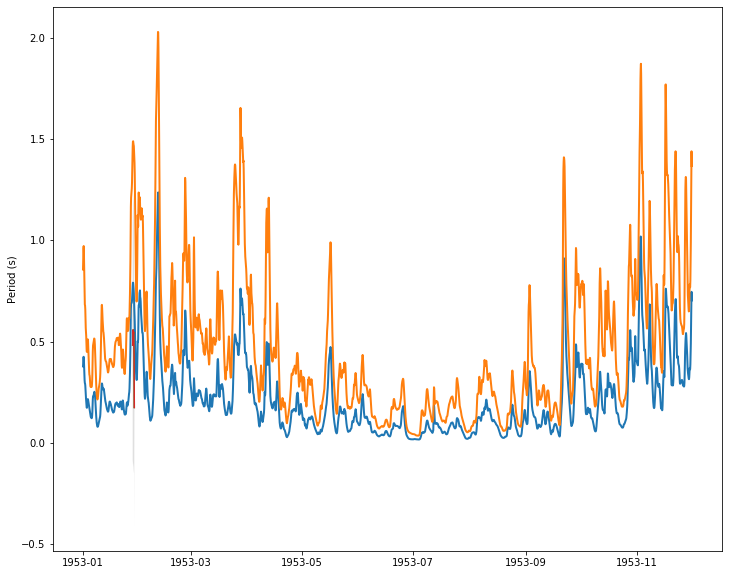

In [27]:
plt.figure(figsize=(12,10))
i = 1
DRMS = {}
for model in models:
    if model.count("Q0200") != 0 or model.count("Q0300") != 0:
#     if model.count("Q0300") != 0:        
        label = model
        model = models[model]
        plt.plot(model.index, model, label=label, lw=2)

i = 1
for comp in results:
    s, d = results[comp]
    s = s.copy()
    d = d.copy()
#     if i == 1:
#         ax = plt.subplot(3,1,1)
#     else:
#         ax = plt.subplot(3,1,i, sharex=ax, sharey=ax)
    plt.ylabel("Period (s)")
    
    drms = s.apply(rms, axis=1)
    DRMS[comp] = drms
#     plt.scatter(drms.index, drms, marker=".", c='k', s=2)
    
    drms3h = drms.resample('3H').mean()
    rs = drms.resample("3H").std()
    plt.plot(drms3h.index, drms3h)
    
    plt.plot(drms3h.index, drms3h ,  label="3H mean +- 3RMS")
    plt.fill_between(drms3h.index, drms3h-rs*3, drms3h+rs*3, zorder=-1, facecolor='silver', alpha=0.5)
    plt.fill_between(drms3h.index, drms3h-rs, drms3h+rs, zorder=-1, facecolor='silver', alpha=0.5)
    
    i += 1
plt.show()

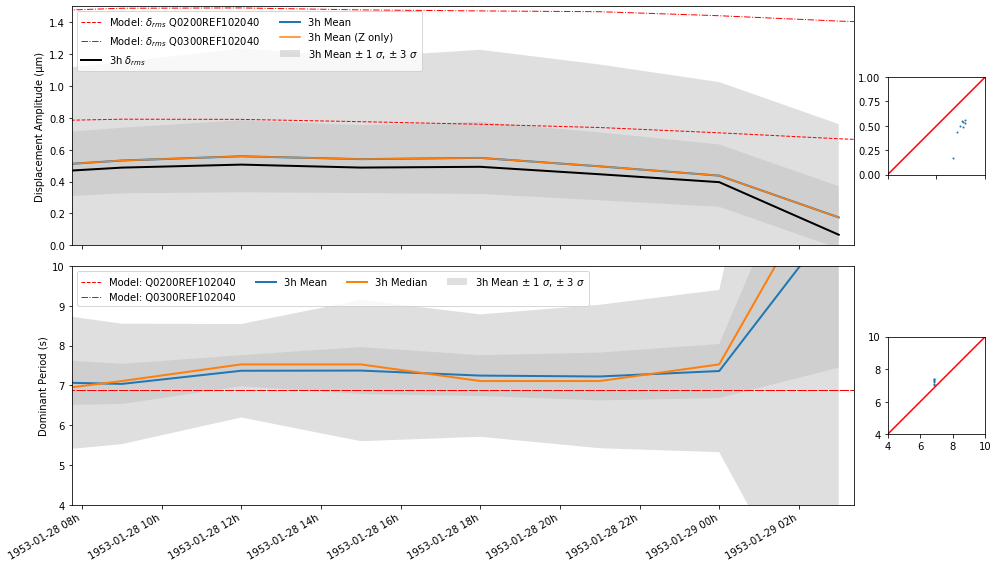

In [35]:
DRMS_mean = pd.concat(DRMS).mean(level=1, axis=0)
plt.figure(figsize=(14,8))
gs = GridSpec(2,2, width_ratios=[8,1], height_ratios=[1,1])

ax= plt.subplot(gs[0])
for model in models:
    label = model.replace("UCC_195301-195311_","").replace("_edzf.nc","")
    label = "Model: $\delta_{rms}$ %s" % label
    if model.count("Q0200") != 0:
        a = models[model]
        plt.plot(a.index, a, label=label, lw=1, c="red", ls="--")
    elif model.count("Q0300") != 0:
        b = models[model]
#         plt.fill_between(b.index, a, b, zorder=0, alpha=0.5)
        plt.plot(b.index, b, label=label, lw=1, c="red", ls="-.")

plt.plot(test2.index, test2, label="3h $\delta_{rms}$", c='k', lw=2)

    
# plt.scatter(DRMS_mean.index, DRMS_mean, s=1, c='k', alpha=0.35)
drms3h = DRMS_mean.resample('3H').mean()
rs = DRMS_mean.resample("3H").std()
r95 = DRMS_mean.resample("3H").quantile(0.9)
plt.plot(drms3h.index, drms3h, lw=2, label="3h Mean")
plt.fill_between(drms3h.index, drms3h-rs*3, drms3h+rs*3, zorder=-1, facecolor='silver', alpha=0.5)
plt.fill_between(drms3h.index, drms3h-rs, drms3h+rs, label="3h Mean $\pm$ 1 $\sigma$, $\pm$ 3 $\sigma$", zorder=-1, facecolor='silver', alpha=0.5)
# plt.plot(r95.index, r95, lw=2, label="percentile 95")


for comp in DRMS:
    _ = DRMS[comp].resample("3H").mean()
    plt.plot(_.index, _, label="3h Mean (%s only)"%comp)




plt.legend(ncol=2, loc=2)
plt.ylabel("Displacement Amplitude (µm)")
plt.ylim(0,1.5)
plt.xlim(drms3h.index[0], drms3h.index[-1])

plt.subplot(gs[1], aspect='equal')
comparison = pd.concat((drms3h, a), axis=1).dropna()
plt.scatter(comparison[1], comparison[0], s=1)
plt.plot([0,1],[0,1], c='r')
plt.xlim(0,1)
plt.ylim(0,1)

plt.subplot(gs[2], sharex=ax)


sp = pd.concat(spectrograms_full)
mm = sp.mean(level=1).T

periods = 1. / mm.idxmax(axis=1)




for model in models:
    if model.count("Q0200") != 0 or model.count("Q0300") != 0:
#     if model.count("Q0200") != 0:
#     if model.count("Q0200") != 0:        
#         label = model.replace("UCC_195301-195311_","").replace("_ezdf.nc","")
        label = model.replace("UCC_195301-195311_","").replace("_edzf.nc","")
        label = "Model: %s" % label
        model = pmax[model]
        
        if label.count("Q0200"):
            a = model
            plt.plot(model.index, 1./model, label=label, lw=1, zorder=0, ls="--", c='r')
        else:
            plt.plot(model.index, 1./model, label=label, lw=1, zorder=0, ls="-.", c='r')

rp = periods.resample("3H")
rs = rp.std()
r = rp.mean()
rmed = rp.median()
plt.plot(r.index, r ,  label="3h Mean", lw=2)
plt.plot(r.index, rmed ,  label="3h Median", lw=2)


plt.fill_between(r.index, r-rs*3, r+rs*3, zorder=-1, facecolor='silver', alpha=0.5)
plt.fill_between(r.index, r-rs, r+rs, label="3h Mean $\pm$ 1 $\sigma$, $\pm$ 3 $\sigma$", zorder=-1, facecolor='silver', alpha=0.5)




plt.gcf().autofmt_xdate()


plt.xlim(s.index[0], s.index[-1])
plt.ylim(4,10)
plt.legend(ncol=4, loc=2)
plt.ylabel("Dominant Period (s)")


plt.subplot(gs[3], aspect='equal')

comparison = pd.concat((r, 1./a), axis=1).dropna()
plt.scatter(comparison[1], comparison[0], s=1)
plt.plot([4,10],[4,10], c='r')
plt.xlim(4,10)
plt.ylim(4,10)

plt.tight_layout()
plt.savefig("amplitude_period_1953.png", dpi=300)


plt.show()
